In [1]:
import warnings
warnings.filterwarnings("ignore")

import warnings
warnings.filterwarnings("ignore")

from collections import Counter, ChainMap
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import utilities.helpers as hp

import pprint

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()

# ALL cases EDA:

# Import data set:

In [2]:
pd.options.mode.chained_assignment = None


df_full = hp.import_dataset(encoding='utf-8')
# Convert json to csv:
# df_full.to_csv('../data/dk_asylum_data_1.csv', encoding='utf-8', index=False)
df_full.shape

(9635, 5)

# Dataset preprocessing:

Keep ALL cases except for Unknown Homeland (Ukendt hjemland):

In [3]:
df_ALL = df_full[df_full.country != "Ukendt hjemland"]

# Drop redundant column:
df_ALL.drop('hasText', axis=1, inplace=True)

df = df_ALL

df["text"] = df["text"].astype("string")

df.shape

(9443, 4)

In [4]:

df.head()

,id,asylum_motive,country,text
0,0,"[Statusændring, Privatretlig forhold, Øvrige...",Syrien,Nævnet omgjorde i maj 2022 Udlændinges...
1,1,"[To-instansbehandling, Bortfald]",Syrien,Nævnet hjemviste i november 2021 Udlæn...
2,2,"[Statusændring, Militære forhold]",Eritrea,Nævnet omgjorde i maj 2022 Udlændinges...
3,3,"[Generelle forhold, Privatretlig forhold]",Afghanistan,Nævnet stadfæstede i maj 2022 Udlændin...
4,4,"[Kriminelle forhold, Privatretlig forhold, S...",Afghanistan,Nævnet stadfæstede i maj 2022 Udlændin...


Check for potential duplicates and drop them:

In [5]:
duplicates_df = df[df.duplicated(['text'], keep='last')]
#pd.concat(g for _, g in df.groupby("text") if len(g) > 1)

# See all duplicates:
duplicates_df

,id,asylum_motive,country,text
131,131,"[Generelle forhold, Øvrige modsætningsforhold...",Syrien,Nævnet omgjorde i november 2021 Udlænd...
132,132,"[Generelle forhold, Øvrige modsætningsforhold...",Syrien,Nævnet omgjorde i november 2021 Udlænd...
521,521,"[Udsendelse (§ 49 a m.v.), Sur Place, Privat...",Afghanistan,Nævnet stadfæstede i juli 2021 Udlændi...
1098,1098,"[Konsekvensstatus, Statusændring, Politiske ...",Syrien,Nævnet meddelte i oktober 2020 opholds...
1142,1142,"[Seksuelle forhold, Overgreb, Etniske forhol...",Den Demokratiske Republik Congo (DR Congo),Nævnet stadfæstede i september 2020 Ud...
...,...,...,...,...
9388,9388,"[Politiske forhold, Agents of Persecution, T...",Afghanistan,Nævnet meddelte i juli 2010 opholdstilladelse ...
9582,9582,[Politiske forhold],Afghanistan,Nævnet stadfæstede i juni 2005 Udlændi...
9594,9594,[Privatretlig forhold],Afghanistan,Nævnet stadfæstede i december 2005 Udl...
9602,9602,[Politiske forhold],Afghanistan,Nævnet stadfæstede i april 2004 en afg...


See shape of new data frame:

In [6]:
# Drop duplicates from original dataframe based on text column
# If the summary is the same probalbly were are looking at a duplicate
# without taking into account all other variables(columns):
df = df.drop_duplicates('text', keep='last')
# Check shape again:
df.shape

(8963, 4)

## Length of texts

Create a numeric column in order to get a feel about the length of the texts. 

In [7]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8963.0,4825.259846,2830.033440,0.0,2307.5,4858.0,7343.5,9634.0
length,8963.0,4159.678456,2212.306528,407.0,2636.0,3771.0,5153.5,24044.0


## Boxplot:

<AxesSubplot:>

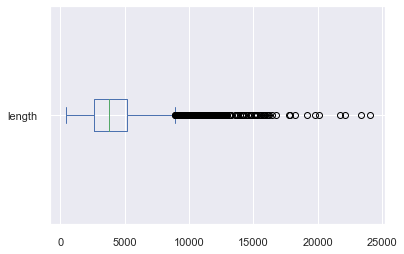

In [8]:
# Box plot:
df['length'].plot(kind='box', vert=False)

# Text Processing:

Column `text` is processed in order to extract data concerning:
- decision outcome
- gender of applicants
- year of decision

Steps included in the pipeline:
- lower casing
- punctuation removal
- stopword removal
- single letter word removal
- tokenization
- lemmatization

In [9]:
pipeline = [str.lower, hp.remove_punctuation, hp.remove_stopwords, hp.drop_single_letter_words,
            hp.tokenize, hp.lemmatize]

In [10]:
# Apply the process:
df['tokens'] = df['text'].apply(hp.process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)

See ten first entries

In [11]:
df.head(10)

,id,asylum_motive,country,text,length,tokens,num_tokens
0,0,"[Statusændring, Privatretlig forhold, Øvrige...",Syrien,Nævnet omgjorde i maj 2022 Udlændinges...,7751,"[omgjorde, 2022, udlændingestyrels, afgørelse,...",600
1,1,"[To-instansbehandling, Bortfald]",Syrien,Nævnet hjemviste i november 2021 Udlæn...,2009,"[hjemvise, 2021, udlændingestyrels, afgørelse,...",147
2,2,"[Statusændring, Militære forhold]",Eritrea,Nævnet omgjorde i maj 2022 Udlændinges...,2670,"[omgjorde, 2022, udlændingestyrels, afgørelse,...",196
3,3,"[Generelle forhold, Privatretlig forhold]",Afghanistan,Nævnet stadfæstede i maj 2022 Udlændin...,6695,"[stadfæste, 2022, udlændingestyrels, afgørelse...",573
4,4,"[Kriminelle forhold, Privatretlig forhold, S...",Afghanistan,Nævnet stadfæstede i maj 2022 Udlændin...,11359,"[stadfæste, 2022, udlændingestyrels, afgørelse...",899
5,5,"[Politiske forhold, Privatretlig forhold]",Rwanda,Nævnet stadfæstede i maj 2022 Udlændin...,7232,"[stadfæste, 2022, udlændingestyrels, afgørelse...",471
6,6,"[Inddragelse/forlængelse, Privatretlig forhold]",Afghanistan,Nævnet omgjorde i maj 2022 Udlændinges...,4902,"[omgjorde, 2022, udlændingestyrels, afgørelse,...",355
7,7,"[Øvrige modsætningsforhold til myndighederne, ...",Syrien,Nævnet omgjorde i maj 2022 Udlændinges...,6470,"[omgjorde, 2022, udlændingestyrels, afgørelse,...",442
8,8,"[Udsendelse (§ 49 a m.v.), Militære forhold, ...",Iran,Nævnet stadfæstede i maj 2022 Udlændin...,4017,"[stadfæste, 2022, udlændingestyrels, afgørelse...",302
9,9,"[Dublin, Artikel 18 (Den ansvarlige medlemsst...",Tyskland,Nævnet stadfæstede i april 2022 Udlænd...,3971,"[stadfæste, 2022, udlændingestyrels, afgørelse...",288


# Country of Origin:

In [12]:
df_country_nan = df['country'].replace(r'^\s*$', np.nan, regex=True) # replace empty string with nan
df_country_nan = df_country_nan.dropna() # remove nan
df_country_nan = df_country_nan.value_counts()[:].to_frame('count')
df_country_nan


,count
Afghanistan,1710
Iran,1474
Irak,1117
Syrien,877
Somalia,874
...,...
Honduras,1
Nordkorea,1
Island,1
Cypern,1


Plot top ten countries:

In [13]:
colors = ['#941f14', '#177487']
gradient_colors = cm.Reds(np.linspace(1, 0, 20))

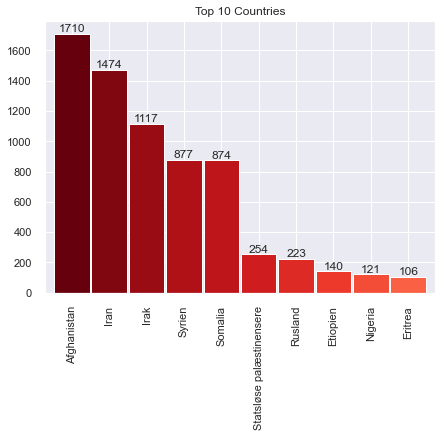

In [14]:
ax = df['country'].replace(r'^\s*$', np.nan, regex=True).value_counts().sort_values(ascending=False).iloc[:10].plot(
    kind='bar', title='Top 10 Countries', rot=90, width=0.95, figsize=(7, 5), color=gradient_colors)

for container in ax.containers:
    ax.bar_label(container)


# Decision extraction:

In [15]:
df['tokens_joined'] = [' '.join(token) for token in df['tokens']]

In [16]:
df_stad = df['tokens_joined'].str.contains('stadfæst.*?', regex=True) # affirmed decision of Immigration Services
df_hem = df['tokens_joined'].str.contains('hjemvis.*?', regex=True) # overturned decision of Immigration Services
df_med = df['tokens_joined'].str.contains('meddel.*?', regex=True) # overturned decision of Immigration Services
df_omg = df['tokens_joined'].str.contains('omgjor.*?|omgør.*?', regex=True) # overturned decision of Immigration Services
df_ame = df['tokens_joined'].str.contains('ændr.*?', regex=True) # overturned decision of Immigration Services
df_oph = df['tokens_joined'].str.contains('ophæv.*?', regex=True) # overturned decision of Immigration Services

df['decision'] = np.where(df_stad, 'affirmed', np.where(df_hem | df_med | df_omg | df_ame | df_oph, 'overturned', np.nan))

Plot decision:

Text(0, 0.5, 'outcomes')

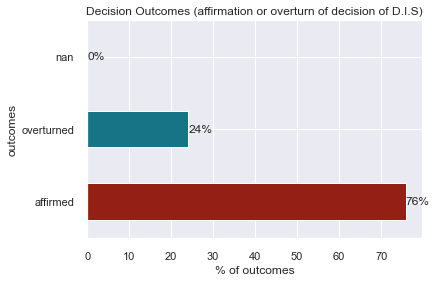

In [17]:
# Plot with normalized values:
ax = df['decision'].value_counts(normalize=True).mul(100).round(1).plot(
    kind='barh', color=colors, title='Decision Outcomes (affirmation or overturn of decision of D.I.S)')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')
ax.set_xlabel('% of outcomes')
ax.set_ylabel('outcomes')

# Uncomment to plot frequencies:
# ax = df['decision'].value_counts().plot(
#     kind='barh', color=colors, title='Decision Outcomes for Unknown Homeland')
# ax.bar_label(container)


Plot decision outcome rate by country:

In [18]:
countries = df.groupby(df['country'])['decision'].value_counts(dropna=False)

countries.to_frame('count')

count
country     decision         
            affirmed       39
            overturned     11
Afghanistan affirmed     1271
            overturned    439
Albanien    affirmed       14
...                       ...
Zambia      affirmed        3
            overturned      2
Zimbabwe    overturned      4
            affirmed        3
Østrig      affirmed       10

[187 rows x 1 columns]

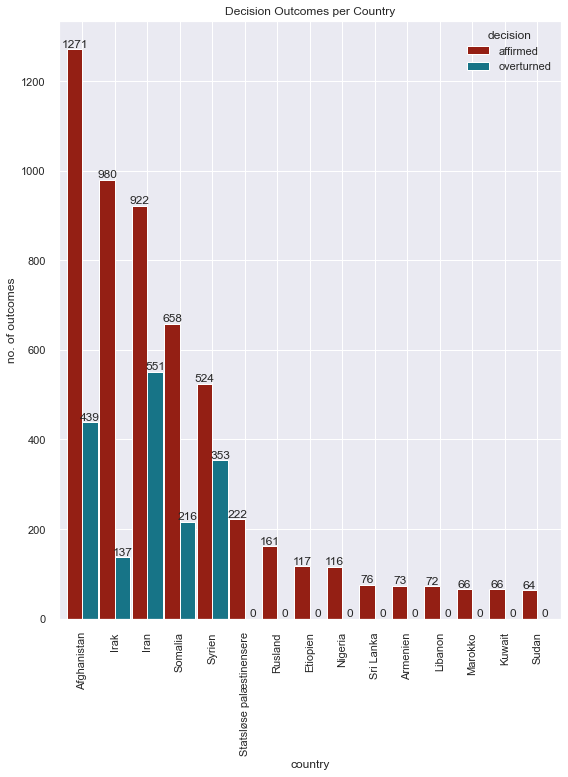

In [19]:
ax = df.groupby(df['country'])['decision'].value_counts().sort_values(ascending=False).iloc[:20].unstack().plot(
    kind='bar', title='Decision Outcomes per Country', rot=90, width=0.95, figsize=(9, 11), color=colors)
# ax.invert_yaxis()
ax.set_ylabel('no. of outcomes')
# ax.set_ylabel('country')

for container in ax.containers:
    ax.bar_label(container)


# Gender of applicants extraction:

In [20]:
male_pat = 'mandl.*?statsborg.*?|mand.*?ansøg.*?|mand.*?klag.*?'
female_pat = 'kvinde.*?statsborg.*?|kvinde.*?ansøg.*?|kvinde.*?klag.*?'
couple_pat = 'ægtepar.*?'

df_female = df['text'].str.contains(female_pat)
df_male = df['text'].str.contains(male_pat)
df_couple = df['text'].str.contains(couple_pat)

df['gender'] = np.where(df_male, "male", np.where(df_female, "female", np.where(df_couple, 'couples', 'unidentified')))


Text(0, 0.5, 'nn. of outcomes')

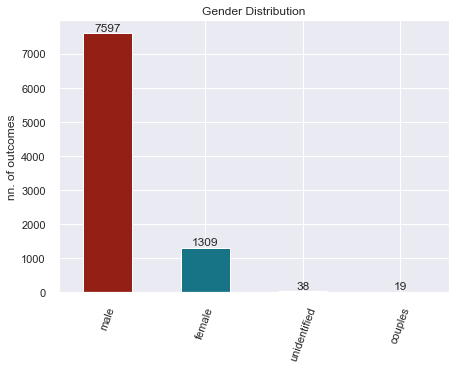

In [21]:
ax = df['gender'].value_counts().plot(kind='bar', rot=70, title='Gender Distribution', figsize=(7,5), color=colors)

for container in ax.containers:
    ax.bar_label(container)
ax.set_ylabel('nn. of outcomes')
# ax.set_ylabel('gender')


# Year of decision:

In [22]:
df['year'] = df['tokens_joined'].str.extract(r'(\d{4})') # match 4 four digits that appear in string 

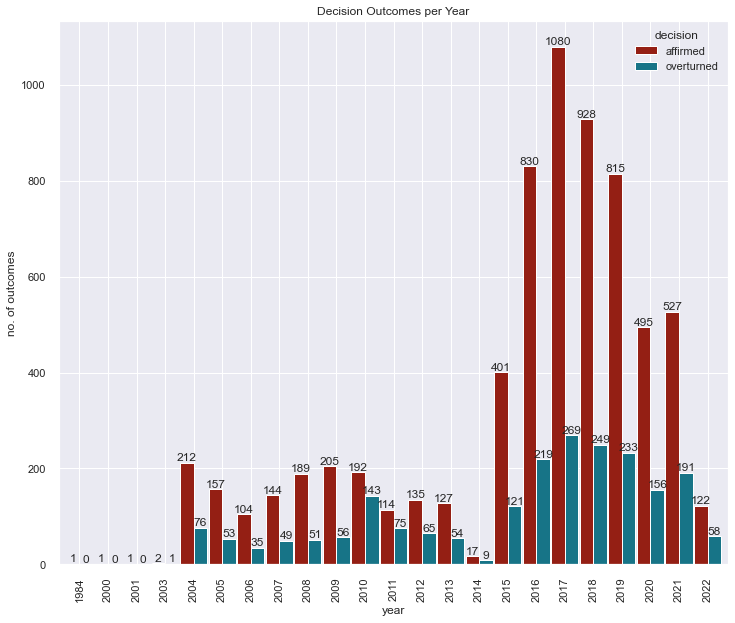

In [23]:
ax = df.groupby(df['year'])['decision'].value_counts().unstack().plot(
    kind='bar', title='Decision Outcomes per Year', figsize=(12,10), width=0.95, color=colors)
ax.set_xlabel('year')
ax.set_ylabel('no. of outcomes')

for container in ax.containers:
    ax.bar_label(container)

Plot Decision Outcome Frequencies by Gender for each Year:

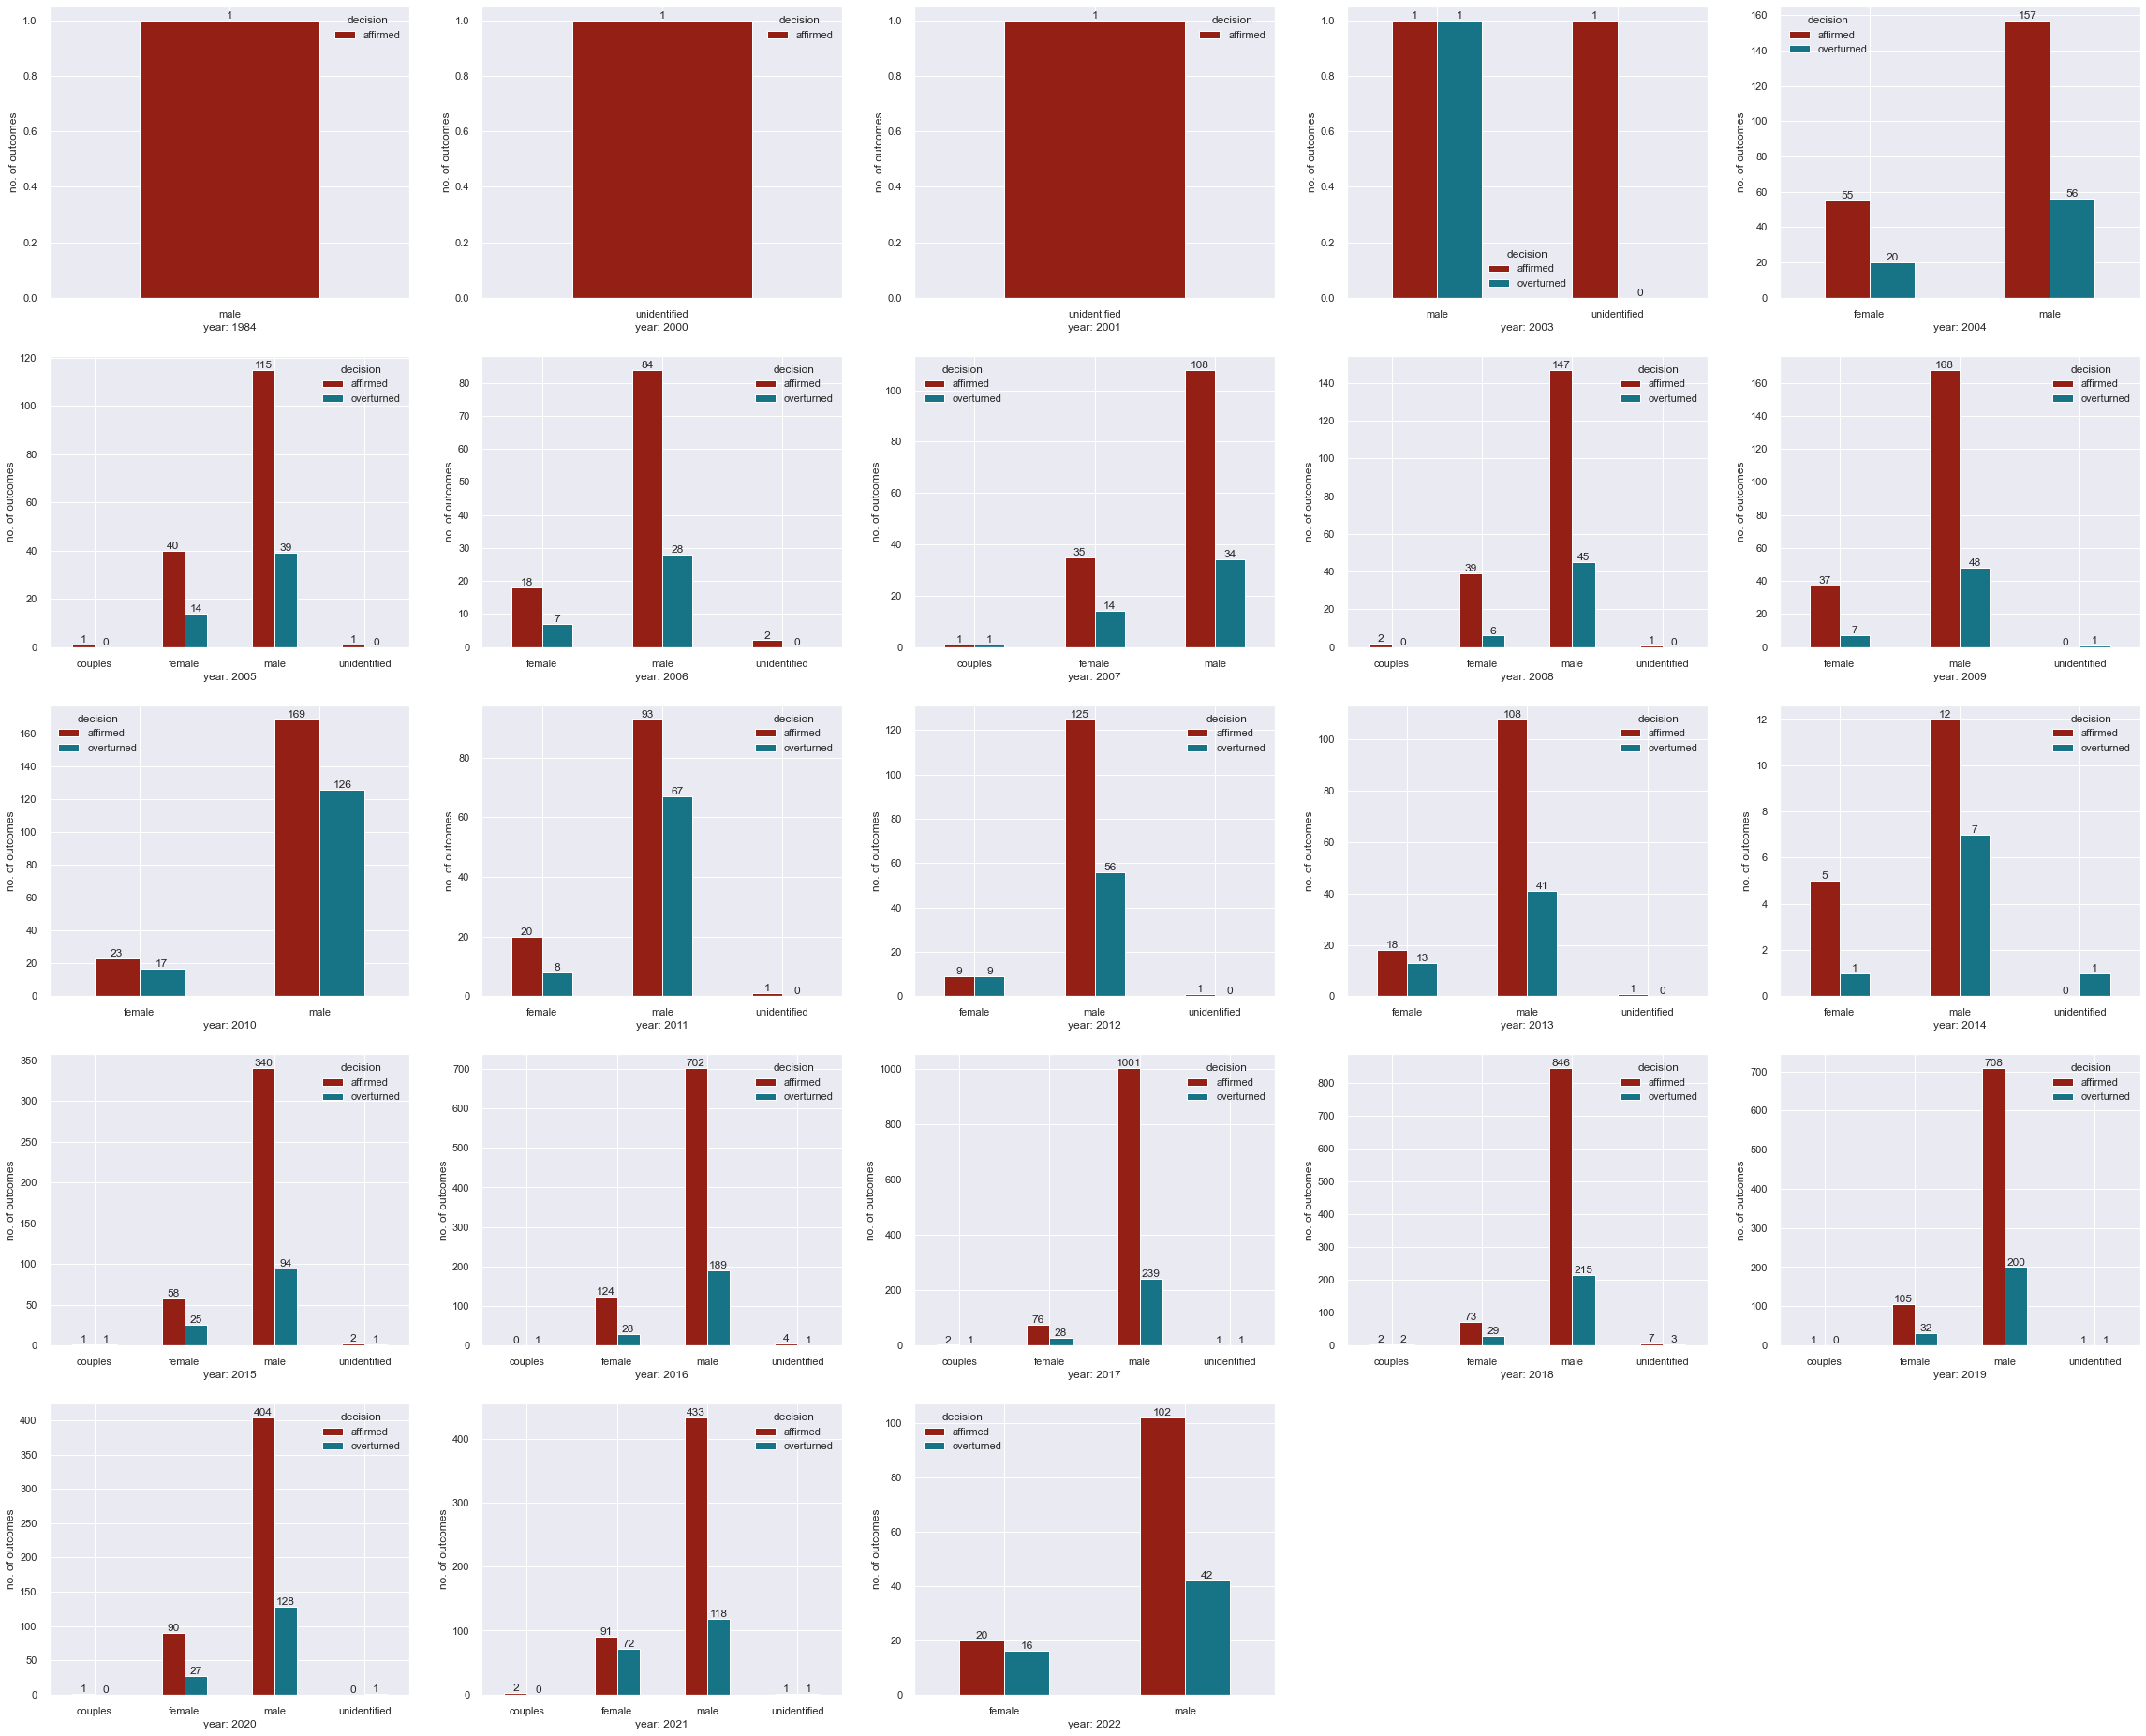

In [24]:
# Uncomment to plot separate figures:
# for year in df['year'].unique():
#     ax = df[df.year==year].groupby(['gender'])['decision'].value_counts().unstack().plot(
#     kind='bar', title='Decision Outcomes by Gender for Unknown Homeland for '+ str(year))
#     ax.set_xlabel('gender')
#     ax.set_ylabel('no. of outcomes')

#     for container in ax.containers:
#         ax.bar_label(container)

# Plot all figures in one
plt.figure(figsize=(40, 40))
for ix, (key, group) in enumerate(df.groupby('year')):
    ax = plt.subplot(6, 5, ix+1, autoscale_on=True)
    group.groupby('gender')['decision'].value_counts().unstack().plot(
        kind='bar', rot=0, ax=ax, color=colors)
    ax.set_xlabel('year: {}'.format(key))
    ax.set_ylabel('no. of outcomes')
    for container in ax.containers:
        ax.bar_label(container)


# Asylum motives distribution:

In [25]:

df['asylum_motive'] = df['asylum_motive'].astype("string")

df_motives = df['asylum_motive'].str.split(',').explode().str.strip('[\'\'] ').value_counts()

df_motives


Agents of Persecution                                         2383
Politiske forhold                                             2365
Privatretlig forhold                                          1853
Generelle forhold                                             1838
Religiøse forhold                                             1355
                                                              ... 
Artikel 3                                                        2
Pas-sager                                                        1
TagCollectionMotive                                              1
Artikel 9 (familiemedlemmer med international beskyttelse)       1
Artikel 8 (uledsagede mindreårige)                               1
Name: asylum_motive, Length: 65, dtype: int64

Plot ten most frequent asylum motives:

Text(0, 0.5, 'Frequency')

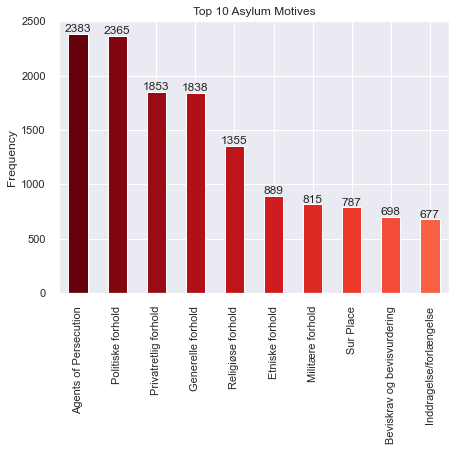

In [26]:
ax = df_motives.iloc[:10].plot(kind='bar', color=gradient_colors,
                               rot=90, title='Top 10 Asylum Motives', figsize=(7, 5))

for container in ax.containers:
    ax.bar_label(container)
ax.set_ylabel('Frequency')


# Search for specific terms:

- Bidoon:

In [27]:
df['bidoon'] = df['tokens_joined'].str.extract(r'(bidoo.?)', hp.re.IGNORECASE)
df['bidoon'].value_counts().to_frame('counts')

,counts
bidoon,86
Bidoon,2


Merge categories and count again:

In [28]:
df['bidoon'] = df['bidoon'].replace('Bidoon', 'bidoon')
df['bidoon'].value_counts().to_frame('counts')

,counts
bidoon,88


See some context:

In [29]:
hp.kwic(df['text'], 'bidoon', print_samples=10)

10 random samples out of 467 contexts for 'bidoon':
ner i Kuwait, der er årsag til hans udrejse. Det fremgår af baggrundsoplysninger om situationen for  bidoon er i Kuwait, at etniske bidoonere udsættes for diskrimination, og at de har begrænsede rettigheder. 
n) fra Kuwait. Indrejst i 2015.Flygtningenævnet udtalte: ”Ansøgeren har oplyst, at han er statsløs ( bidoon ) og shia muslim fra […], Kuwait. Ansøgeren har ikke været medlem af politiske eller religiøse foren
 Flygtningenævnet udtalte: ”Ansøgeren er etnisk araber og shia-muslim. Ansøgeren har oplyst at være  bidoon  (statsløs) fra [A], Kuwait. Ansøgeren har ikke været medlem af politiske eller religiøse foreninger
e: ”Den mandlige ansøger er etnisk araber og shiamuslim. Den mandlige ansøger har oplyst, at han er  bidoon  (statsløs) fra […], Al-Ahmadi, Kuwait. Den mandlige ansøger har deltaget i én demonstration til for
ns han ved indrejse i Danmark har oplyst navnet [D], født [i efteråret] 1993, og at han er statsløs  bidoon  fra

Decision outcomes for bidooners outside Unknown Homeland.

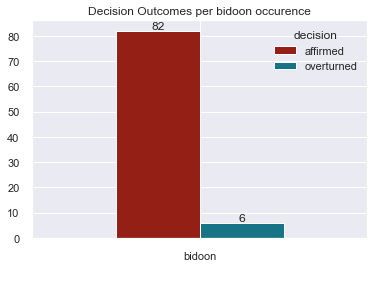

In [30]:
ax = df.groupby('bidoon')['decision'].value_counts().unstack().plot(
    kind='bar', title='Decision Outcomes per bidoon occurence', rot=0, color=colors)
ax.set_xlabel(' ')
# ax.set_ylabel('no. of outcomes')

for container in ax.containers:
    ax.bar_label(container)


# Natural Language Processing:


## Frequency analysis:

Here the most frequent tokens in the **whole** corpus are counted.

The table below presents top ten words.


In [31]:
# See ten most frequent words in the whole corpus:
freq_df = hp.count_words(df)
freq_df.head(10)

# See all words with their frequencies:
# pd.value_counts(np.hstack(df['tokens']))

,freq
token,
ansøger,134357
klager,36862
lægge,27478
stk,25983
finde,25739
forklare,25148
grund,21476
udlændingelov,21365
forklaring,20625


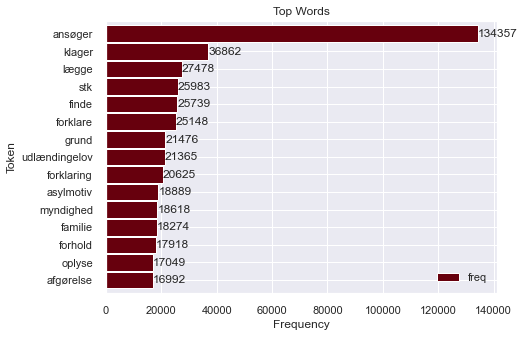

In [32]:
# Plot the results:
ax = freq_df.head(15).plot(kind='barh', width=0.95, color=gradient_colors, figsize=(7,5))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

for container in ax.containers:
    ax.bar_label(container)


## N-gram analysis:

In [33]:
values = defaultdict(int)

# Get the count of every bigram in the data set from last processed column:
for text in df['tokens_joined']:
    for word in hp.generate_N_grams(text, 2):
        values[word] += 1

In [34]:
# Focus on more frequently occuring words and sort in descending order with respect to the column of interest:
df_processed = pd.DataFrame(
    sorted(values.items(), key=lambda x: x[1], reverse=True))

# Rename dataframe columns:
df_processed.columns = ['Bigrams', 'Frequency']

Text(0, 0.5, 'Frequencies')

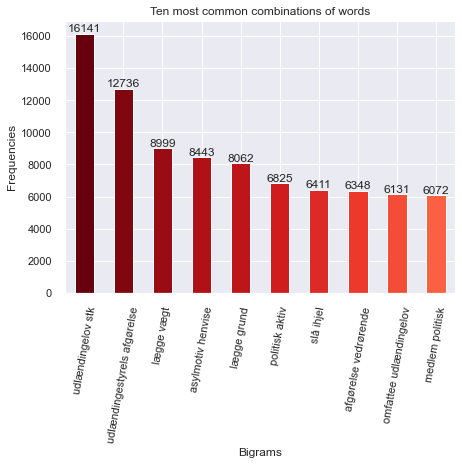

In [35]:
# Plot ten most common combinations of Bigrams:
ax = df_processed.set_index('Bigrams')['Frequency'].iloc[:10].plot(kind='bar', color=gradient_colors,
                               rot=80, title='Ten most common combinations of words', figsize=(7, 5))

for container in ax.containers:
    ax.bar_label(container)
ax.set_ylabel('Frequencies')

## TF-IDF


Below is the shape of the resulting vector of the vocabulary created from the given context.


In [36]:
# Get the column of interest:
docs = df['tokens_joined'].tolist()

# Create a vocabulary of words:

cv = CountVectorizer()
word_count_vector = cv.fit_transform(docs)

# Get shape of resulting vector:
word_count_vector.shape


(8963, 50262)

Ten random words from the vocabulary:


In [37]:
# Look at 10 words from our vocabulary:
list(cv.vocabulary_.keys())[:10]

['omgjorde',
 '2022',
 'udlændingestyrels',
 'afgørelse',
 'sag',
 'statusændring',
 'vedrørende',
 'kvindelig',
 'statsborger',
 'syrien']

Peek at the IDF values array:


In [38]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)


# Peek at the IDF values:
tfidf_transformer.idf_

array([9.40782465, 9.40782465, 8.71467747, ..., 9.40782465, 9.40782465,
       8.71467747])

In [39]:
# We only need to do this once:
feature_names = cv.get_feature_names_out()

# Generate tf-idf for all documents in list. docs has 189 documents:
tf_idf_vector = tfidf_transformer.transform(cv.transform(docs))

results = []
for i in range(tf_idf_vector.shape[0]):

    # get vector for a single document
    curr_vector = tf_idf_vector[i]

    # sort the tf-idf vector by descending order of scores
    # tocoo() Return a COOrdinate representation of this matrix.
    sorted_items = hp.sort_coo(curr_vector.tocoo())

    # extract only the top n; n here is 10
    keywords = hp.extract_top_n_from_vector(feature_names, sorted_items, 10)

    results.append(keywords)

df_tfIDF = pd.DataFrame(zip(docs, results), columns=['doc', 'keywords'])
# df_tfIDF.shape
df_tfIDF

,doc,keywords
0,omgjorde 2022 udlændingestyrels afgørelse sag ...,"{'klager': 0.443, 'exmand': 0.255, 'syrien': 0..."
1,hjemvise 2021 udlændingestyrels afgørelse sag ...,"{'storesøster': 0.493, 'klager': 0.469, 'ansøg..."
2,omgjorde 2022 udlændingestyrels afgørelse sag ...,"{'eritrea': 0.428, 'klager': 0.364, 'føde': 0...."
3,stadfæste 2022 udlændingestyrels afgørelse ved...,"{'afghanistan': 0.334, 'the': 0.311, 'of': 0.2..."
4,stadfæste 2022 udlændingestyrels afgørelse ved...,"{'afghanistan': 0.309, 'the': 0.276, '2021': 0..."
...,...,...
8958,meddele 2004 opholdstilladelse kstatus mandlig...,"{'dostum': 0.322, 'rang': 0.305, 'khad': 0.291..."
8959,meddele 2004 opholdstilladelse fstatus ægtepar...,"{'afghanistan': 0.473, 'taleban': 0.201, 'magt..."
8960,stadfæste 2004 udlændingestyrels afgørelse ved...,"{'hezbewahdat': 0.392, 'kommandant': 0.267, 'a..."
8961,stadfæste 2004 udlændingestyrels afgørelse ved...,"{'hezbewahdat': 0.456, 'krigstjeneste': 0.287,..."


Twenty most common words based on TF-IDF values


In [40]:
# Create a dictionary from results list of dictionaries:
my_dict = dict(ChainMap(*results))

c = Counter(my_dict)

# Returns top 20 most common pairs:
most_common = c.most_common(20)

# For getting the keys from `most_common`:
my_keys = [key for key, val in most_common]

# Add pretty printer:
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(most_common)

[   ('gulbuddin', 0.893),
    ('letland', 0.866),
    ('kklan', 0.86),
    ('honduras', 0.859),
    ('marjan', 0.837),
    ('fatima', 0.829),
    ('hawadleklan', 0.826),
    ('javed', 0.82),
    ('gaza', 0.816),
    ('aslægt', 0.812),
    ('studiekammerat', 0.795),
    ('cypern', 0.795),
    ('ezmary', 0.79),
    ('xbevægelse', 0.787),
    ('galadiklan', 0.78),
    ('g1', 0.764),
    ('litauen', 0.762),
    ('murad', 0.759),
    ('niloufar', 0.758),
    ('bazmohammad', 0.758)]


Plotting the pairs:


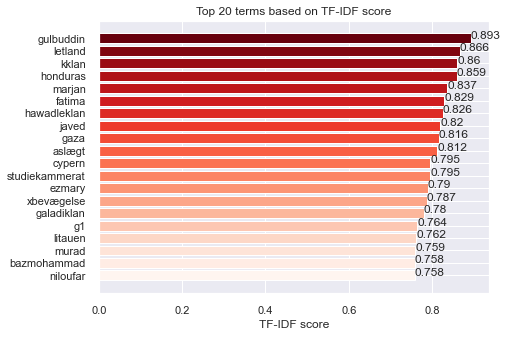

In [41]:
# sort by key and return a tuple:
sorted_most_common = sorted(most_common, key=lambda x: x[1])

# unpack a list of pairs into two tuples:
x, y = zip(*sorted_most_common)

plt.figure(figsize=(7, 5))

plt.barh(x, y, color=gradient_colors[::-1])

for k, v in enumerate(y):
    plt.text(v, k, str(v))

plt.xlabel('TF-IDF score')
# plt.ylabel('Tokens')
plt.title('Top 20 terms based on TF-IDF score')
plt.show()